In [1]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

url = 'crowd_change1.csv'
#df1 = pd.read_csv(url)
# series = read_csv(url, header=0, index_col=0, parse_dates=True, squeeze=True)
series = read_csv(url, header=0, index_col=0, parse_dates=True)
series
# print(series)

,Current Total Count
Time,
2005-07-24 00:00:00,0
2005-07-24 00:30:00,-1
2005-07-24 01:00:00,-1
2005-07-24 01:30:00,-1
2005-07-24 02:00:00,-1
...,...
2005-11-04 21:30:00,42
2005-11-04 22:00:00,42
2005-11-04 22:30:00,41


In [2]:
df = pd.read_csv('crowd_change.csv', engine='python')

# interpolation for "Time"
df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)
for dd in df['Time'].index:
  if dd%2 == 1:
    df['Time'].iloc[dd].values = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)

df.index = df['Time']
df.drop(columns=['Time'], inplace=True)
timeseries = df[["Current Total Count"]].values.astype('float32')


/tmp/ipykernel_853324/2702083590.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)


In [3]:
series = df['Current Total Count']
series

Time
2005-07-24 00:00:00     0
2005-07-24 00:00:00     0
2005-07-24 00:30:00    -1
2005-07-24 00:30:00    -1
2005-07-24 01:00:00    -1
                       ..
2005-11-05 22:30:00   -23
2005-11-05 23:00:00   -23
2005-11-05 23:00:00   -23
2005-11-05 23:30:00   -24
2005-11-05 23:30:00   -24
Name: Current Total Count, Length: 10080, dtype: int64

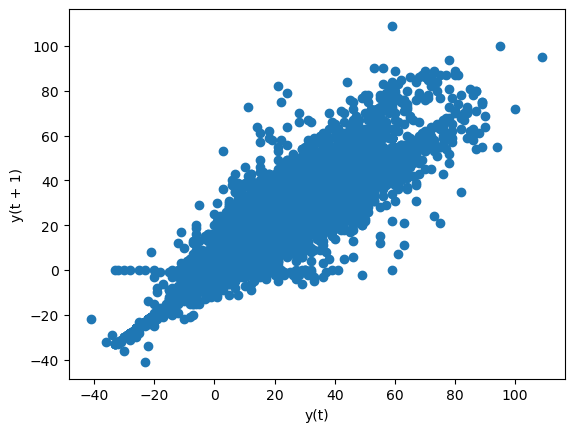

In [4]:
from pandas.plotting import lag_plot
# series = read_csv(url, header=0, index_col=0)
lag_plot(series)
plt.show()

In [5]:
from pandas import concat
# series = read_csv(url, header=0, index_col=0)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.926471
t+1  0.926471  1.000000


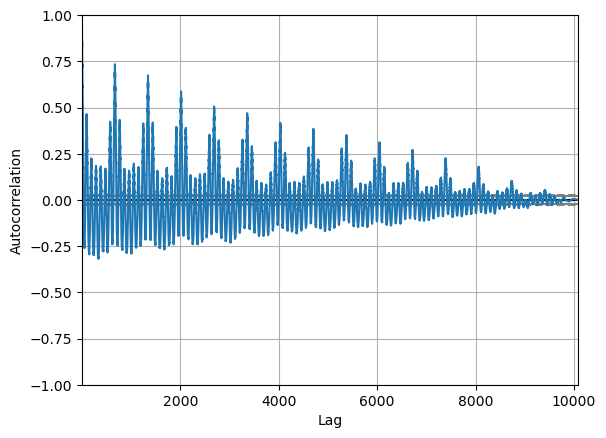

In [6]:
from pandas.plotting import autocorrelation_plot
# series = read_csv(url, header=0, index_col=0)
autocorrelation_plot(series)
plt.show()

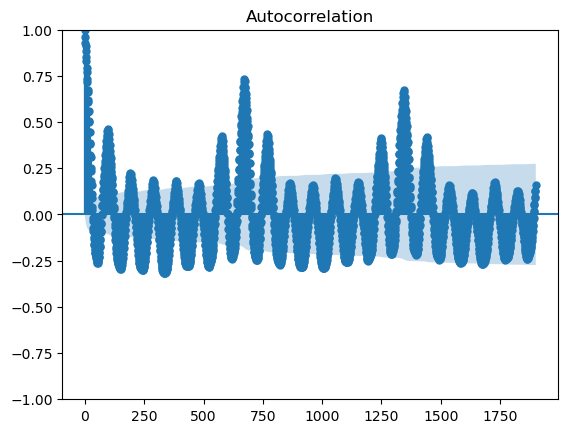

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
# series = read_csv(url, header=0, index_col=0)
plot_acf(series, lags=1900)
plt.show()

In [8]:
# split dataset
X = series.values
# train, test = X[1:len(X)-48], X[len(X)-48:]

# train-test split for time series
train_size = int(len(series) * 0.8)
test_size = len(series) - train_size
train, test = series.values[:train_size], series.values[train_size:]


from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# train autoregression
# model = AutoReg(train, lags=500)
model = AutoReg(train, lags=1500)
# model = AutoReg(train, lags=3000)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
further_pred_length: int = 500
predictions = model_fit.predict(start=len(train),
                                end=len(train)+len(test)-1+further_pred_length,
                                dynamic=False,
                                # dynamic=True,
                                )
# for i in range(len(predictions)):
	# print('predicted=%f, expected = %d' % (predictions[i], test[i]))
for i in range(len(test)):
  if i % 30 == 0:
    print(f'[{i}] predicted={predictions[i]}, expected = {test[i]}')
rmse = sqrt(mean_squared_error(test, predictions[:len(test)]))
print('Test RMSE: %.3f' % rmse)

Coefficients: [ 0.54041321  0.75085751  0.3452387  ...  0.01724893 -0.00935631
 -0.01133593]
[0] predicted=-19.45180360871242, expected = -3
[30] predicted=-1.5931829588438018, expected = -4
[60] predicted=-3.100600194716886, expected = -11
[90] predicted=-6.038828939482198, expected = -33
[120] predicted=-1.0349773618595304, expected = -1
[150] predicted=32.49147433518192, expected = 54
[180] predicted=37.33581631433518, expected = 47
[210] predicted=5.895204617368014, expected = -5
[240] predicted=22.178708537795334, expected = 9
[270] predicted=37.34454446481401, expected = 7
[300] predicted=-1.54097565664987, expected = 0
[330] predicted=9.64737663250564, expected = 28
[360] predicted=23.22460898665402, expected = 56
[390] predicted=-4.1443141526715745, expected = -3
[420] predicted=-1.9023026139408747, expected = 2
[450] predicted=30.879074103053057, expected = 31
[480] predicted=-5.189050525881287, expected = -1
[510] predicted=1.1070518481583769, expected = -7
[540] predicted=41

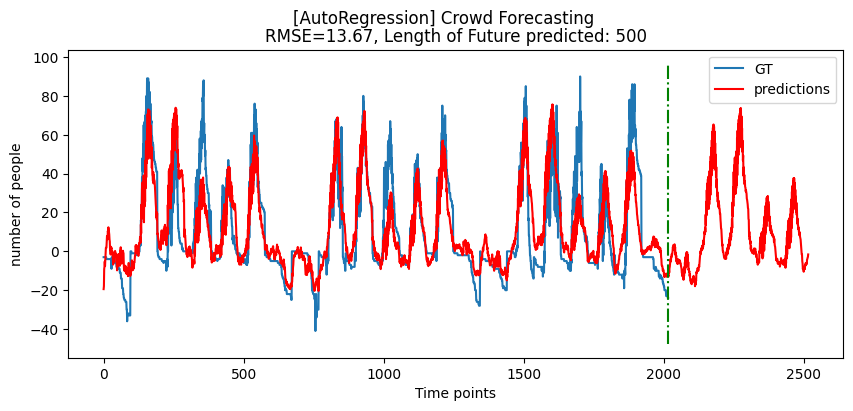

In [9]:
# plot results
fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle('[AutoRegression] Crowd Forecasting')
ax.set_title(f'RMSE={rmse:.2f}, Length of Future predicted: {further_pred_length}')
ax.set_xlabel('Time points')
ax.set_ylabel('number of people')
ax.plot(test, label='GT')
ax.plot(predictions, color='red', label='predictions')
y_lower, y_upper = ax.get_ybound()
ax.vlines(x=len(test), ymin=y_lower, ymax=y_upper, colors='g', linestyles='dashdot')
ax.legend()
plt.show()

In [11]:
import mysql.connector

connection = mysql.connector.connect(host='***',
                                     port='***',
                                     user='***',
                                     password='***') 

cursor = connection.cursor()

#create database
#cursor.execute("CREATE DATABASE `crowd_fore`;")

#get all name of database
# cursor.execute("SHOW DATABASES;")
# records = cursor.fetchall()
# for r in records:
#     print(r)

# use database
cursor.execute("USE `crowd_fore`;")

# create table
#cursor.execute("CREATE TABLE `forecast`(TID VARCHAR(14) , PD INT , GT INT , RMSE DECIMAL(4,2) , TP INT)")

# # 執行 SQL 查詢
# cursor.execute("SELECT * FROM forecast;")  # 假設你的資料表名稱是 forecast

# # 取得查詢結果
# result = cursor.fetchall()

# 將預測結果、真實值、RMSE 和時間點存入資料庫
for i in range(len(test)):
    if i % 30 == 0:
        TID = i  # 取得當前的 timestamp
        PD = float(predictions[i])  # 將 numpy.float64 轉換成 float
        GT = float(test[i])  # 將 numpy.float64 轉換成 float
        TP = int(len(train) + i)  # 將 numpy.int64 轉換成 int
        RMSE = float(sqrt(mean_squared_error(test, predictions[:len(test)])))  # 將 numpy.float64 轉換成 float

        # 建立插入資料的 SQL 查詢
        sql = "INSERT INTO forecast (TID, PD, GT, RMSE, TP) VALUES (%s, %s, %s, %s, %s);"
        values = (TID, PD, GT, RMSE, TP)

        # 執行插入資料
        cursor.execute(sql, values)
        connection.commit()

# 執行 SQL 查詢來取得資料表的標題
cursor.execute("DESCRIBE forecast;")  # 假設你的資料表名稱是 forecast

# 取得查詢結果，即欄位名稱
columns = [column[0] for column in cursor.fetchall()]

# 印出標題
print("資料表標題：")
print(columns)

# 執行 SQL 查詢來取得資料表內容
cursor.execute("SELECT * FROM forecast;")

# 取得查詢結果，即資料表內容
data = cursor.fetchall()

# 印出內容
print("資料表內容：")
for row in data:
    print(row)
    
#close the database and disconnection with mysql
cursor.close()
connection.close()

資料表標題：
['TID', 'PD', 'GT', 'RMSE', 'TP']
資料表內容：
('0', -19, -3, Decimal('13.67'), 8064)
('30', -2, -4, Decimal('13.67'), 8094)
('60', -3, -11, Decimal('13.67'), 8124)
('90', -6, -33, Decimal('13.67'), 8154)
('120', -1, -1, Decimal('13.67'), 8184)
('150', 32, 54, Decimal('13.67'), 8214)
('180', 37, 47, Decimal('13.67'), 8244)
('210', 6, -5, Decimal('13.67'), 8274)
('240', 22, 9, Decimal('13.67'), 8304)
('270', 37, 7, Decimal('13.67'), 8334)
('300', -2, 0, Decimal('13.67'), 8364)
('330', 10, 28, Decimal('13.67'), 8394)
('360', 23, 56, Decimal('13.67'), 8424)
('390', -4, -3, Decimal('13.67'), 8454)
('420', -2, 2, Decimal('13.67'), 8484)
('450', 31, 31, Decimal('13.67'), 8514)
('480', -5, -1, Decimal('13.67'), 8544)
('510', 1, -7, Decimal('13.67'), 8574)
('540', 41, 63, Decimal('13.67'), 8604)
('570', 9, 22, Decimal('13.67'), 8634)
('600', 1, -5, Decimal('13.67'), 8664)
('630', -4, -7, Decimal('13.67'), 8694)
('660', -18, -22, Decimal('13.67'), 8724)
('690', 1, -1, Decimal('13.67'), 8754)
(